# Regression analysis with Python 
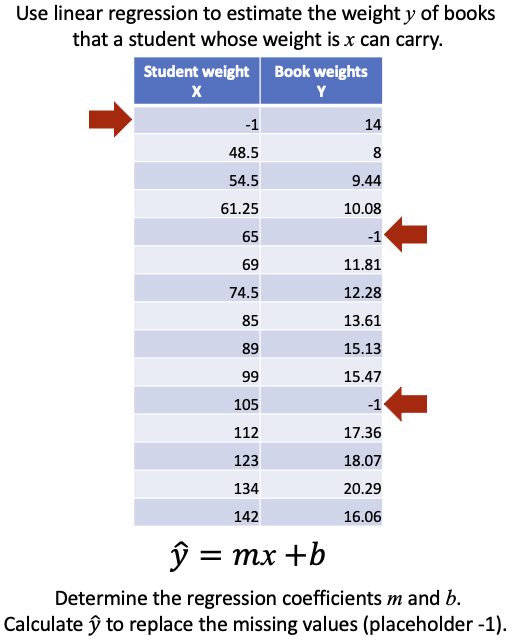

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from DATA225utils import make_connection, dataframe_query

%matplotlib inline

In [4]:
conn = make_connection(config_file = 'StudentBooks.ini')
cursor = conn.cursor()

Exception: Connection failed: 1049 (42000): Unknown database 'studentsbooks'

In [ ]:
cursor.execute('DROP TABLE IF EXISTS weights')

sql = """
    CREATE TABLE weights
    (
        student DOUBLE NOT NULL,
        books   DOUBLE NOT NULL,
        PRIMARY KEY(student, books)
    )
    """

cursor.execute(sql)

## Student and textbook weights with missing values
#### -1 is the placeholder for missing weights.

In [ ]:
student_weights  = [48.50, 54.50, 61.25, 65.00, 69.00, 74.50, 85.00,    -1, 89.00, 99.00, 105.00, 112.00, 123.00, 134.00, 142.00]
textbook_weights = [ 8.00,  9.44, 10.08,    -1, 11.81, 12.28, 13.61, 14.00, 15.13, 15.47,     -1, 17.36,  18.07,  20.29,  16.06 ]

values = list(zip(student_weights, textbook_weights))
values

## Load the `weights` table

In [ ]:
sql = ( """
        INSERT INTO weights
        VALUES (%s, %s)
        """
      )

cursor.executemany(sql, values)
conn.commit()

## Function to display the `weights` table and return its rows

In [ ]:
def display_and_return(cursor):
    """
    Query the weights table, print its rows as a dataframe,
    and return the rows as a numpy array.
    """
    _, df = dataframe_query(conn, """
        SELECT student AS student_weights,
               books AS book_weights
        FROM weights
        """
                           )
    
    display(df)
    return df.to_numpy()

## The dirty `weights` table
#### -1 is the placeholder for missing weights.

In [ ]:
rows = display_and_return(cursor)

## Function to draw a scatter plot with regression line

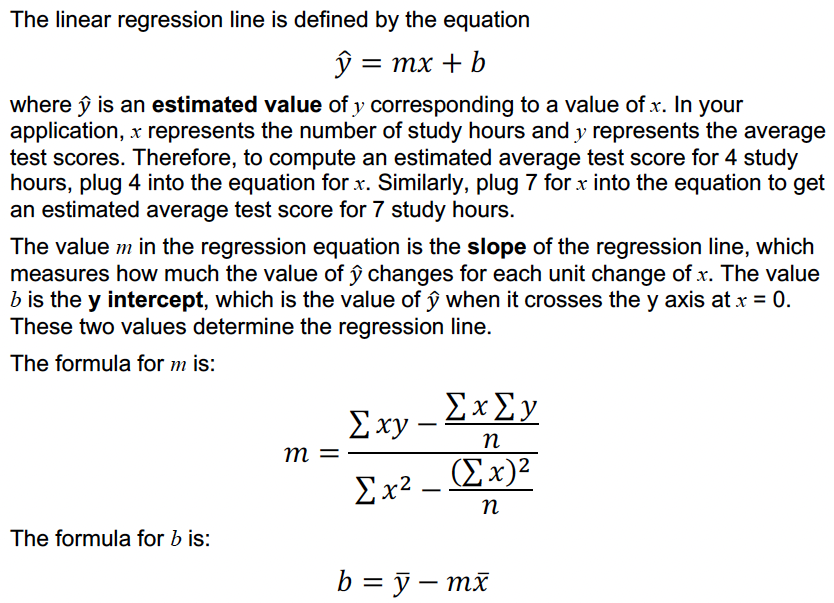
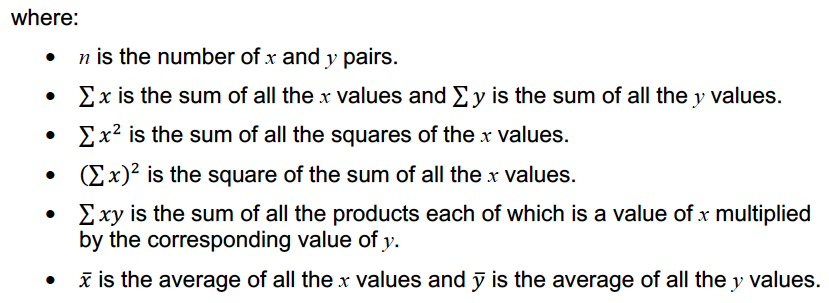

#### Draw the scatter plot. If `draw_trend_line=True`, also draw the linear regression trend line  with slope `m` and y intercept `b`. We only need its end points to plot the line. The x values of the end points are 0 and `X[-1]`, and the y values of the end points are `b` and `m*X[-1] + b]`. The function `plt.plot()` takes a list of the x values and a list of the y values of the line to plot. Let's make the regression line red.

In [ ]:
def draw_graph(X, Y, m=1, b=0, draw_trend_line=False):
    """
    Draw a scatter plot of the vector of X and Y values
    with a linear regression trend line with slope m
    and y intercept b.
    """
    plt.scatter(X, Y)
    
    if draw_trend_line:
        # The regression line. We only need the end points.
        # End point 1: (0, b)
        # End point 2: (X[-1], m*X[-1] + b)
        plt.plot([0, X[-1]], [b, m*X[-1] + b], color='red')

## Obtain the current X and Y vectors from the data

In [ ]:
X = rows[:, 0]
Y = rows[:, 1]

In [ ]:
X

In [ ]:
Y

## Scatter plot of dirty data

In [ ]:
draw_graph(X, Y)

## Remove the rows containing missing values

In [ ]:
i = 0

while i < len(X):
    if (X[i] < 0) or (Y[i] < 0):
        X = np.delete(X, i)
        Y = np.delete(Y, i)
    else:
        i += 1

## Three functions to compute the slope and y intercept

### Using Python lists

In [ ]:
def calculate_slope_intercept_list_version(X, Y):
    """
    Calculate and return the slope m and y intercept b
    of the least-squares linear regression line y = mx + b
    given the vectors of x and y values.
    """
    n = len(X)
    
    sum_X  = 0
    sum_Y  = 0
    sum_XX = 0
    sum_XY = 0

    for i in range(n):
        x = X[i]
        y = Y[i]
        
        sum_X  += x
        sum_Y  += y
        sum_XX += x*x
        sum_XY += x*y
        
    mean_X = sum_X/n
    mean_Y = sum_Y/n
    
    numerator   = sum_XY - (sum_X*sum_Y)/n
    denominator = sum_XX - ((sum_X*sum_X)/n)
    
    m = numerator/denominator
    b = mean_Y - m*mean_X

    return m, b  # slope and intercept    

### Using `numpy` vector arithmetic

In [ ]:
def calculate_slope_intercept_numpy_version(X, Y):
    """
    Calculate and return the slope m and y intercept b
    of the least-squares linear regression line y = mx + b
    given the vectors of x and y values.
    """
    n = len(X)

    sum_X  = np.sum(X)
    sum_Y  = np.sum(Y)
    sum_XX = np.sum(X*X)
    sum_XY = np.sum(X*Y)
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    
    numerator   = sum_XY - (sum_X*sum_Y)/n
    denominator = sum_XX - (sum_X*sum_X)/n
    
    m = numerator/denominator
    b = mean_Y - m*mean_X
    
    return m, b  # slope and intercept    

### Using the `numpy` module's `polyfit()` function

In [ ]:
def calculate_slope_intercept_polyfit_version(X, Y):
    """
    Calculate and return the slope and y-intercept
    of the regression line.
    """
    model = np.polyfit(X, Y, 1)
    return model[0], model[1]  # slope and intercept

## Compute the slope `m` and the y intercept `b` three ways
#### Should get the same results each time.

In [ ]:
m, b = calculate_slope_intercept_list_version(X, Y)

print('List version')
print('------------')
print(f'      slope m = {m:4.2f}')
print(f'y intercept b = {b:4.2f}')

In [ ]:
m, b = calculate_slope_intercept_numpy_version(X, Y)

print('Numpy version')
print('-------------')
print(f'      slope m = {m:4.2f}')
print(f'y intercept b = {b:4.2f}')

In [ ]:
m, b = calculate_slope_intercept_polyfit_version(X, Y)

print('Polyfit version')
print('---------------')
print(f'      slope m = {m:4.2f}')
print(f'y intercept b = {b:4.2f}')

## Compute estimates for the missing `x` and `y` values

In [ ]:
for x in [65, 105]:
    y = m*x + b
    print(f'x = {x:6.2f}, y = {y:5.2f}')

In [ ]:
y = 14
x = (y - b)/m
print(f'x = {x:6.2f}, y = {y:5.2f}')

## Replace the missing values in the `weights` table

In [ ]:
cursor.execute(f"SET @m = {m}")
cursor.execute(f"SET @b = {b}")

cursor.execute('SET SQL_SAFE_UPDATES = 0')

In [ ]:
cursor.execute( """
    UPDATE weights
    SET books = @m*student + @b
    WHERE books < 0
    """
      )

In [ ]:
cursor.execute( """
    UPDATE weights
    SET student = (books - @b)/@m
    WHERE student < 0
    """
      )

In [ ]:
conn.commit()

## The cleaned `weights` table

In [ ]:
rows = display_and_return(cursor)

## The scatter plot of the cleaned data with regression line

In [ ]:
X = rows[:, 0]
Y = rows[:, 1]

draw_graph(X, Y, m, b, draw_trend_line=True)

In [ ]:
cursor.close()
conn.close()

## Error table

In [ ]:
Yhat = m*X + b
Yhat
Errors = Y - Yhat
table = []

for i in range(len(Y)):
    pct = abs(100*Errors[i]/Y[i])
    row = [X[i], Y[i], Yhat[i], Errors[i], pct]
    
    table.append(row)

In [ ]:
df = DataFrame(table)
df.columns = ['student weight', 'books weight', 
              'est. books weight', 'error', '% error']

pd.options.display.float_format = '{:,.2f}'.format
display(df)

print(f'correlation coefficient = {np.corrcoef(Y, Yhat)[0, 1]:.2f}')

#### (c) 2023 by Ronald Mak